#https://www.kaggle.com/code/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert

    https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation/notebook

picked T4GpU on ram

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
#! pip install keras
#from keras.models import Sequential
#from keras.layers.recurrent import LSTM, GRU,SimpleRNN
#while TensorFlow provides a comprehensive machine learning platform with a broader set of functionalities, Keras (as part of TensorFlow or standalone) offers a user-friendly high-level API specifically designed for building and experimenting with neural networks.

#from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.embeddings import Embedding
#from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, SimpleRNN
#from keras.layers.normalization import BatchNormalization
#from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
#from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
#from keras.preprocessing import sequence#, text
#from keras.callbacks import EarlyStopping
#from tensorflow.keras import text

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")


In [ ]:

#Reading the Data¶
from google.colab import drive
drive.mount('/content/drive')


df_train = pd.read_csv('/content/drive/MyDrive/PredictEmotionMELD/new_balanced/train_balanced.csv') # Balanced train data from MELD database
df_test = pd.read_csv('/content/drive/MyDrive/PredictEmotionMELD/new_balanced/test_balanced.csv') # Balanced test data from MELD database
df_validation = pd.read_csv("/content/drive/MyDrive/PredictEmotionMELD/new_balanced/validation_balanced.csv") # Balanced validation data

print(df_train.shape, df_test.shape, df_validation.shape)




Mounted at /content/drive
(1308, 13) (384, 13) (204, 13)


In [ ]:
df_test['Emotion_original'].value_counts()

,count
Emotion_original,
sadness,192
joy,32
surprise,32
fear,32
disgust,32
neutral,32
anger,32


In [ ]:
df_train['Emotion_original'].value_counts()

,count
Emotion_original,
sadness,654
anger,109
neutral,109
disgust,109
joy,109
fear,109
surprise,109


In [ ]:
df_validation['Emotion_original'].value_counts()

,count
Emotion_original,
sadness,102
neutral,17
joy,17
anger,17
fear,17
disgust,17
surprise,17


In [ ]:
df_test.loc[df_test['Emotion_original'] == 'sadness', 'Emotion'] = 1 # Records with 'sad' emotion marked as 1 , rest 0
df_test.loc[df_test['Emotion_original'] != 'sadness', 'Emotion'] = 0

df_train.loc[df_train['Emotion_original'] == 'sadness', 'Emotion'] = 1 # Records with 'sad' emotion marked as 1 , rest 0
df_train.loc[df_train['Emotion_original'] != 'sadness', 'Emotion'] = 0

df_validation.loc[df_validation['Emotion_original'] == 'sadness', 'Emotion'] = 1 # Records with 'sad' emotion marked as 1 , rest 0
df_validation.loc[df_validation['Emotion_original'] != 'sadness', 'Emotion'] = 0


df_train['Utterance'].apply(lambda x:len(str(x).split())).max() #max words in text dataset for in 'text' or 'utterance' column is 69.


69

In [ ]:
print(df_validation)

     Unnamed: 0  Sr No.                                          Utterance  \
0             0     131  Oh my God! Why would you play hide and seek wi...   
1             1       1     Oh my God, hes lost it. Hes totally lost it.   
2             2     245                       Hi, how are you doing Kelly?   
3             3     833  Its just if-if we got together again and it d...   
4             4     587                               Yeah, I guess it is.   
..          ...     ...                                                ...   
199         199     306  Look, when it started I was just trying to be ...   
200         200     834  I mean she-she thinking everything Oh thats...   
201         201    1128                Oh, I was kinda hoping that was it.   
202         202     976  Hey Pheebs, could you please not put your feet...   
203         203     608  I got a call at two in the morning, but all I ...   

    Speaker Emotion_original Sentiment  Dialogue_ID  Utterance_

In [ ]:
xtrain1 = df_train['Utterance']    #Input variable for train dataset
ytrain1 = pd.to_numeric(df_train['Emotion'], errors="coerce").fillna(0).astype('int64') #Output variable for train dataset which is 0 or 1

xtest1 = df_test['Utterance']  #Input variable for test dataset
ytest1 = pd.to_numeric(df_test['Emotion'], errors="coerce").fillna(0).astype('int64') #Output variable for test dataset (0 or 1) which will be compared with the prediction

# Validation will not be used in BERT as choosing differnt epochs lead to similar result.
xvalidation1 = df_validation['Utterance']  #Input variable for test dataset
yvalidation1 = pd.to_numeric(df_validation['Emotion'], errors="coerce").fillna(0).astype('int64') #Output variable for test dataset (0 or 1)  which will be compared with the prediction


In [ ]:
print(ytest1.value_counts())

Emotion
0    192
1    192
Name: count, dtype: int64


In [ ]:
# import BERT-base pretrained model
# BERT is a pretrained contextual model that generates a representation of each word that is based on the other words in the sentence and captures the relationship between words in the text bidirectionally.
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# tokenize and encode sequences in the training set
# The model breaks sentences into tokens and can help generate text to answer questions or predict an output based on text. nondepressed will be broken into 2 tokens 'un' and 'well', so not words.
tokens_train = tokenizer.batch_encode_plus(
    xtrain1.tolist(),
    max_length = 69,
    pad_to_max_length=True, # the returned sequences will be padded according to the model’s padding side and padding index, up to their max length. This allows for all the text values to be same length
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    xtest1.tolist(),
    max_length = 69,
    pad_to_max_length=True, # the returned sequences will be padded according to the model’s padding side and padding index, up to their max length. This allows for all the text values to be same length
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_validation = tokenizer.batch_encode_plus(
    xvalidation1.tolist(),
    max_length = 69,
    pad_to_max_length=True, # the returned sequences will be padded according to the model’s padding side and padding index, up to their max length. This allows for all the text values to be same length
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
## convert lists to tensors (machine learning array for pytorch)

train_seq = torch.tensor(tokens_train['input_ids']) #The tokenizer returns a dictionary with all the arguments necessary for its corresponding model to work properly.
train_mask = torch.tensor(tokens_train['attention_mask']) #The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value.
train_y = torch.tensor(ytrain1.tolist())

test_seq = torch.tensor(tokens_test['input_ids']) #The tokenizer returns a dictionary with all the arguments necessary for its corresponding model to work properly.
test_mask = torch.tensor(tokens_test['attention_mask']) #The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value.
test_y = torch.tensor(ytest1.tolist())

validation_seq = torch.tensor(tokens_validation['input_ids']) #The tokenizer returns a dictionary with all the arguments necessary for its corresponding model to work properly.
validation_mask = torch.tensor(tokens_validation['attention_mask']) #The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value.
validation_y = torch.tensor(yvalidation1.tolist())


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size =40

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
val_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):


    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(ytrain1),
                                        y = ytrain1
                                    )
#class_weights = dict(zip(np.unique(ytrain1), class_weights))
class_weights

print("Class Weights:",class_weights)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Class Weights: [1. 1.]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 75

In [ ]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [ ]:
import datetime
import time
import datetime
# set initial loss to infinite
best_test_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
test_losses=[]


#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    test_loss, _ = evaluate()

    #save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    test_losses.append(test_loss) # Not using validation data here, as number of epochs were not impacted.

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {test_loss:.3f}')



 Epoch 1 / 75

Evaluating...

Training Loss: 0.695
Validation Loss: 0.691

 Epoch 2 / 75

Evaluating...

Training Loss: 0.687
Validation Loss: 0.686

 Epoch 3 / 75

Evaluating...

Training Loss: 0.687
Validation Loss: 0.684

 Epoch 4 / 75

Evaluating...

Training Loss: 0.686
Validation Loss: 0.682

 Epoch 5 / 75

Evaluating...

Training Loss: 0.683
Validation Loss: 0.682

 Epoch 6 / 75

Evaluating...

Training Loss: 0.679
Validation Loss: 0.680

 Epoch 7 / 75

Evaluating...

Training Loss: 0.679
Validation Loss: 0.679

 Epoch 8 / 75

Evaluating...

Training Loss: 0.680
Validation Loss: 0.678

 Epoch 9 / 75

Evaluating...

Training Loss: 0.675
Validation Loss: 0.678

 Epoch 10 / 75

Evaluating...

Training Loss: 0.676
Validation Loss: 0.676

 Epoch 11 / 75

Evaluating...

Training Loss: 0.678
Validation Loss: 0.676

 Epoch 12 / 75

Evaluating...

Training Loss: 0.679
Validation Loss: 0.675

 Epoch 13 / 75

Evaluating...

Training Loss: 0.674
Validation Loss: 0.675

 Epoch 14 / 75

Eval

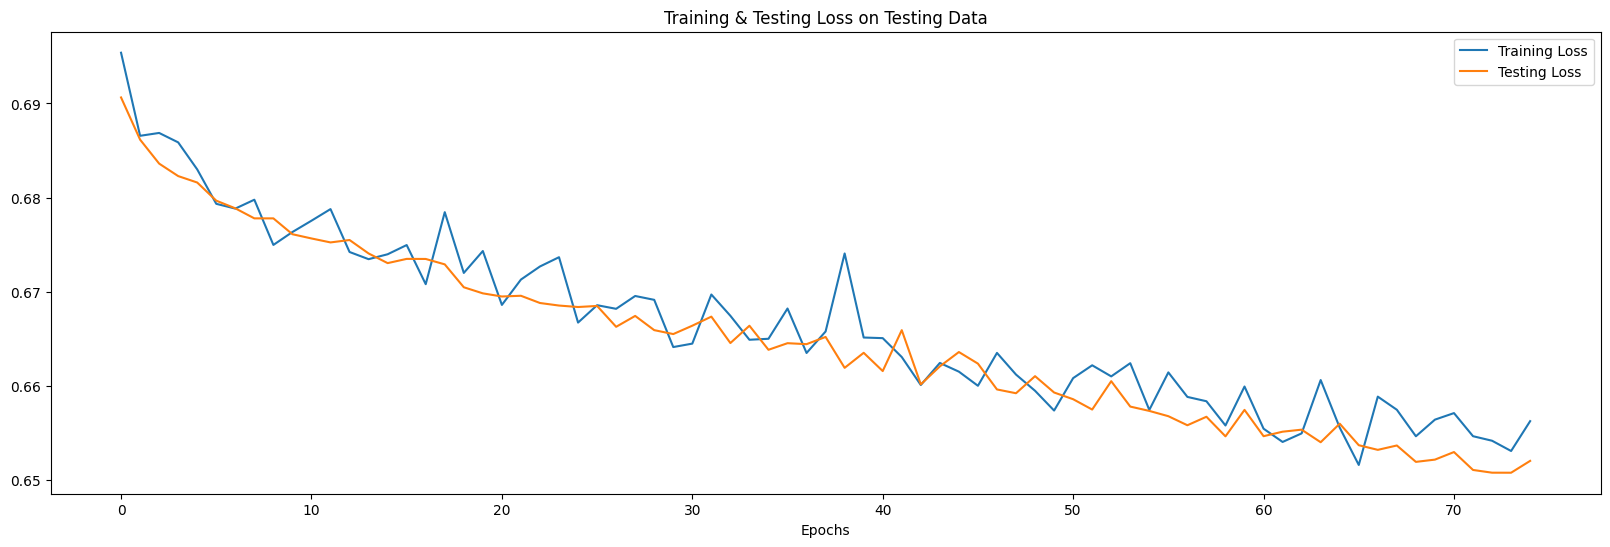

In [ ]:
#print("Accuracy of our model on test data : " , model.evaluate(xtest1,ytest1)[1]*100 , "%")


epochs = [i for i in range(75)]
fig , ax = plt.subplots()#1,2)

fig.set_size_inches(20,6)
ax.plot(epochs , train_losses , label = 'Training Loss')
ax.plot(epochs , test_losses , label = 'Testing Loss')
ax.set_title('Training & Testing Loss on Testing Data')
ax.legend()
ax.set_xlabel("Epochs")

plt.show()

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<ipython-input-21-5a29cc8ec3f6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# model's performance
#delprint= pd.DataFrame(preds).to_csv('/content/drive/MyDrive/PredictEmotionMELD/del1.csv', index=False)

In [ ]:
print(preds) # This is log of Prediction values

[[-0.73755133 -0.6506311 ]
 [-0.43309793 -1.0455371 ]
 [-0.8959571  -0.5246149 ]
 [-0.9520261  -0.4876923 ]
 [-0.6062922  -0.7882697 ]
 [-1.0722777  -0.41889712]
 [-0.9120999  -0.51362926]
 [-0.8162958  -0.58351487]
 [-0.6381578  -0.7513374 ]
 [-0.85372174 -0.55482477]
 [-0.93405086 -0.49915844]
 [-0.8903793  -0.52848065]
 [-1.0186359  -0.44798732]
 [-0.37089702 -1.171554  ]
 [-0.91317356 -0.5129092 ]
 [-0.7409868  -0.6474921 ]
 [-1.1552751  -0.37829396]
 [-0.80409235 -0.59329087]
 [-0.8902092  -0.528599  ]
 [-0.64351356 -0.7453735 ]
 [-0.46669525 -0.9863678 ]
 [-1.0380898  -0.43715772]
 [-0.59151965 -0.8062836 ]
 [-0.6032778  -0.79189783]
 [-0.7943419  -0.60125834]
 [-1.0891747  -0.4102174 ]
 [-0.66881686 -0.7180842 ]
 [-0.48693818 -0.95322704]
 [-1.0566378  -0.4271321 ]
 [-0.8491844  -0.5582032 ]
 [-0.6730298  -0.7136777 ]
 [-0.8442286  -0.561924  ]
 [-0.83882415 -0.5660185 ]
 [-0.9197292  -0.5085398 ]
 [-0.45717186 -1.0025883 ]
 [-1.0453019  -0.43322533]
 [-1.2085326  -0.3547271 ]
 

In [ ]:
print(preds[:,1])
pred_upload=np.exp(preds[:,1]) # Applied log function to get value from 0 to 1.

[-0.6506311  -1.0455371  -0.5246149  -0.4876923  -0.7882697  -0.41889712
 -0.51362926 -0.58351487 -0.7513374  -0.55482477 -0.49915844 -0.52848065
 -0.44798732 -1.171554   -0.5129092  -0.6474921  -0.37829396 -0.59329087
 -0.528599   -0.7453735  -0.9863678  -0.43715772 -0.8062836  -0.79189783
 -0.60125834 -0.4102174  -0.7180842  -0.95322704 -0.4271321  -0.5582032
 -0.7136777  -0.561924   -0.5660185  -0.5085398  -1.0025883  -0.43322533
 -0.3547271  -0.6036234  -0.58015907 -0.9398508  -0.59564507 -0.7488433
 -0.743558   -0.60128796 -0.9164233  -0.7291081  -0.829807   -0.47336036
 -0.8520855  -0.44645256 -0.95662475 -0.49182054 -0.6600347  -0.59117335
 -0.7615574  -0.8118708  -0.5312855  -0.4943232  -0.53869516 -0.67621696
 -0.48874712 -0.52965885 -0.46505803 -1.0201485  -0.6943157  -0.81540877
 -0.7398629  -0.37888053 -0.46108913 -0.96979666 -0.83221215 -0.6302176
 -0.51659244 -0.8334072  -0.5915296  -0.82509863 -0.44272563 -0.50114393
 -0.88534725 -0.622408   -0.41814    -0.8979275  -0.62

In [ ]:
print(pred_upload)


[0.5217164  0.35150298 0.5917833  0.6140418  0.45463073 0.6577719
 0.5983202  0.55793387 0.47173527 0.57417285 0.6070413  0.58949995
 0.6389128  0.30988503 0.5987512  0.5233566  0.6850291  0.5525061
 0.58943015 0.47455704 0.37292877 0.64586955 0.4465144  0.4529843
 0.54812145 0.663506   0.48768565 0.385495   0.65237737 0.57223636
 0.48983938 0.57011116 0.56778157 0.6013731  0.3669285  0.6484144
 0.7013649  0.54682666 0.55980927 0.3906861  0.5512069  0.47291327
 0.47541937 0.54810524 0.39994696 0.48233902 0.4361334  0.6229056
 0.4265245  0.6398941  0.38418746 0.6115121  0.51683336 0.55367726
 0.46693867 0.4440266  0.5878488  0.6099836  0.58350915 0.5085372
 0.61339444 0.58880585 0.62809867 0.36054137 0.4994161  0.44245845
 0.47717932 0.6846274  0.63059646 0.37916014 0.43508574 0.5324759
 0.59654987 0.4345661  0.55348    0.43819177 0.6422834  0.6058373
 0.4125709  0.5366506  0.65827006 0.40741313 0.5354322  0.42351446
 0.42694074 0.33785248 0.48064286 0.40316096 0.61157733 0.510723
 0.42

In [ ]:
preds = np.argmax(preds, axis = 1) # Predictions as 0 or 1 which is 'not-depressed' or 'depressed' as it picks 1 if likelyhood of depression is more than 0.5



In [ ]:
print(preds)

[1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0
 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0
 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1
 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1
 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1
 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1
 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1
 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0
 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1
 0 1 1 1 1 1 0 1 0 0 0 1 1 0]


In [ ]:
print(classification_report(test_y, preds))


              precision    recall  f1-score   support

           0       0.67      0.54      0.60       192
           1       0.62      0.73      0.67       192

    accuracy                           0.64       384
   macro avg       0.64      0.64      0.63       384
weighted avg       0.64      0.64      0.63       384



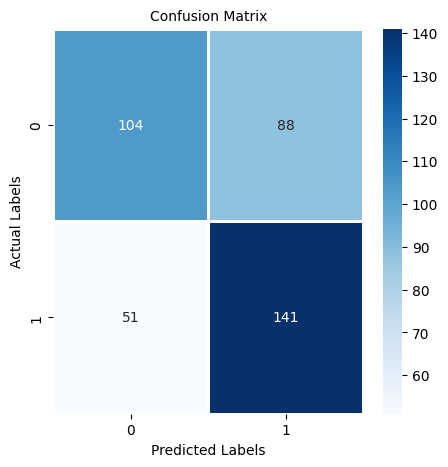

In [ ]:
import seaborn as sns # Confusion matrix with test data
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_y, preds)
plt.figure(figsize = (5, 5))
cm = pd.DataFrame(cm , index = ["0","1"] , columns = ["0","1"])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=10)
plt.xlabel('Predicted Labels', size=10)
plt.ylabel('Actual Labels', size=10)
plt.show()

In [ ]:
import pandas as pd
df_csv = pd.concat([df_test, pd.DataFrame(pred_upload, columns =['Text_model_probability']), pd.DataFrame(preds, columns =['Text_model_01'])], axis=1) #Create a file of all the predictions which will be combined with other modes


df_csv.to_csv('/content/drive/MyDrive/PredictEmotionMELD/new_balanced/output_text_bal_test.csv', index=False)

[-0.81537765 -0.62585413 -0.57633424 -0.41208595 -0.5060251  -0.61573607
 -0.41320214 -0.74516433 -0.6323163  -0.57642215 -0.51079005 -0.63600147
 -0.579412   -1.139229   -0.7759448  -0.8196689  -0.61149234 -0.65734476
 -0.47820807 -0.44910967 -0.5999309  -0.40307298 -0.66020536 -0.9898207
 -0.7847782  -0.9331498  -0.35385978 -0.74744624 -0.8767353  -0.570605
 -0.40644675 -0.8798817  -0.7524792  -0.7419501  -0.50374955 -0.89099294
 -0.62333715 -0.6097448  -1.017878   -0.34674475 -0.6201755  -0.8265227
 -0.44978088 -0.5124816  -0.8476504  -0.74272    -0.8548523  -0.63473344
 -0.416256   -0.6811262  -0.6650196  -0.94266415 -0.39289844 -0.7254452
 -0.6266854  -0.55455875 -0.78979385 -1.1027915  -1.094285   -0.60474086
 -0.5066693  -1.0358343  -0.44276208 -0.70535403 -0.52815974 -0.36824498
 -0.8062762  -0.6415295  -0.7323618  -0.8938591  -0.4832533  -0.81135494
 -0.7799727  -1.1740676  -0.7232612  -0.80546755 -0.63642675 -0.48192433
 -0.93822527 -0.4441642  -0.81806695 -0.48494762 -0.5960

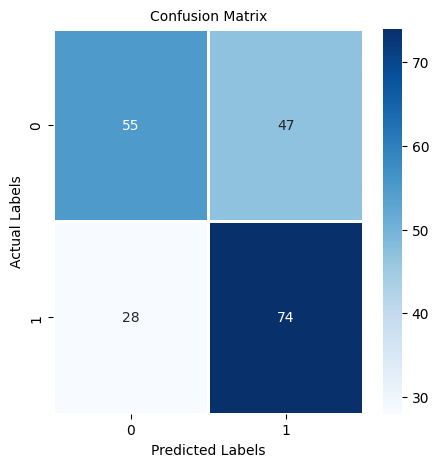

In [ ]:
# get predictions and Confusion matrix with validation data
with torch.no_grad():
    preds_validation = model(validation_seq.to(device), validation_mask.to(device))
    preds_validation = preds_validation.detach().cpu().numpy()
print(preds_validation[:,1])
pred_upload=np.exp(preds_validation[:,1]) # Applied log function to get value from 0 to 1.
preds_val = np.argmax(preds_validation, axis = 1) # Predictions as 0 or 1 which is 'not-depressed' or 'depressed' as it picks 1 if likelyhood of depression is more than 0.5
validation_y.shape, preds_validation.shape

print(classification_report(validation_y, preds_val))

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(validation_y, preds_val)
plt.figure(figsize = (5, 5))
cm = pd.DataFrame(cm , index = ["0","1"] , columns = ["0","1"])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=10)
plt.xlabel('Predicted Labels', size=10)
plt.ylabel('Actual Labels', size=10)
plt.show()

df_csv = pd.concat([df_validation, pd.DataFrame(pred_upload, columns =['Text_model_probability']), pd.DataFrame(preds_val, columns =['Text_model_01'])], axis=1) #Create a file of all the predictions which will be combined with other modes


df_csv.to_csv('/content/drive/MyDrive/PredictEmotionMELD/new_balanced/output_text_bal_validation.csv')

[-0.98490846 -0.98767525 -0.553835   ... -0.9833276  -0.62294745
 -0.54523623]
              precision    recall  f1-score   support

           0       0.65      0.57      0.61       654
           1       0.62      0.69      0.65       654

    accuracy                           0.63      1308
   macro avg       0.63      0.63      0.63      1308
weighted avg       0.63      0.63      0.63      1308



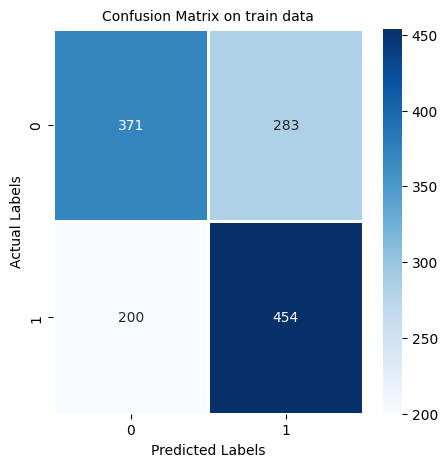

In [ ]:
# get predictions and Confusion matrix with train data
with torch.no_grad():
    preds_train = model(train_seq.to(device), train_mask.to(device))
    preds_train = preds_train.detach().cpu().numpy()
print(preds_train[:,1])
pred_upload=np.exp(preds_train[:,1]) # Applied log function to get value from 0 to 1.
preds_val = np.argmax(preds_train, axis = 1) # Predictions as 0 or 1 which is 'not-depressed' or 'depressed' as it picks 1 if likelyhood of depression is more than 0.5
validation_y.shape, preds_train.shape

print(classification_report(train_y, preds_val))

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(train_y, preds_val)
plt.figure(figsize = (5, 5))
cm = pd.DataFrame(cm , index = ["0","1"] , columns = ["0","1"])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix on train data', size=10)
plt.xlabel('Predicted Labels', size=10)
plt.ylabel('Actual Labels', size=10)
plt.show()

df_csv = pd.concat([df_train, pd.DataFrame(pred_upload, columns =['Text_model_probability']), pd.DataFrame(preds_val, columns =['Text_model_01'])], axis=1) #Create a file of all the predictions which will be combined with other modes


df_csv.to_csv('/content/drive/MyDrive/PredictEmotionMELD/new_balanced/output_text_bal_train.csv')